<a href="https://colab.research.google.com/github/alirempel/cap-comp215/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Circle Simulation
###A customizable simulation of circles colliding made using matplotlib.

 Author: Alison Rempel

 Date: 2024-02-05


---



###Credits:

https://github.com/alirempel/cap-comp215/blob/main/lessons/algorithms/06-animation-2d.ipynb for the base of the CircleAnimation class

https://saturncloud.io/blog/how-to-draw-a-circle-with-matplotlibpyplot-a-guide-for-data-scientists/  for how to add circles to a matplotlib plot

https://github.com/alirempel/cap-comp215/blob/main/lessons/week03-objects.ipynb for the base of the circle class



# **TO DO**
# * **FIX JANKY CORNER COLLISIONS AND 180 BALL COLLISIONS**
# * **MAYBE ADD END DESCRIPTION?**


Below are the imported modules and brief descriptions of where they were used (for the non self explanatory modules)

In [176]:
import matplotlib.pyplot as plt
import math
import itertools # for checking circle collisions
import matplotlib.patches # for drawing circles in Simulation's draw method

# for CircleAnimation class
import time
from matplotlib import animation
from IPython.display import clear_output



##Customizable variables:
*These are set to values that go well with the simulation but feel free to mess around!!*


* *X* is the size you would like the width of the window of the simulation to be (must be positive INT, recommended below 150 if you don't want to zoom out)
* *Y* is the size you would like the height of the window of the simulation to be (must be positive INT, recommended below 50 if you don't want to zoom out)
* *interval* is the time in seconds for how fast you want the animation to complete a step (must be positive FLOAT or INT)
* *num_circles* is the number of circles you would like in the simulation (must be a positive INT)

  **IMPORTANT NOTE: The below variables are <u>lists</u>, and the length must be the same as num_circles**
* *circle_radii* is a LIST of the sizes of each circle's radius (each entry must be an INT)
* *circle_positions* is a LIST of the starting positions for each circle (each entry must be a **TUPLE** with 2 INTs and within the window size)
* *circle_directions* is a LIST of the circle's directions as angles (each entry must be an INT between 0 and 360)



In [177]:
X = 50
Y = 50
interval = 0.1

num_circles = 2

circle_radii = [5,5]
circle_positions = [(20,20),(40,40)]
circle_directions = [45,225]

## Circle Class
The Circle class represents one circle in the simulation. It's parameters are the circle's radius (float), the circle's starting centre position (two length tuple of ints), and the angular direction its going to go (int).

Its methods are...
* __move__: takes no inputs. It moves the circle one step in the direction specified using trig.
* __distance__: takes another Circle object as input and calculates the distance between the two.
* __intersects__: takes another circle as input and uses distance method to check if the circles are intersecting

In [178]:

class Circle:
    """ Representation for the data and operations on a circle """

    def __init__(self, radius:float, centre:tuple, direction:int):
      assert len(centre) == 2
      self.radius = radius
      self.centre = centre
      self.direction = direction # angle its heading (degs)
      self.x = round(math.cos(math.radians(direction)),2) # how much to move in the x axis each step
      self.y = round(math.sin(math.radians(direction)),2) # how much to move in the y axis each step

    def move(self):
        """ Move the circle according to current direction """
        x_step = round(math.cos(math.radians(self.direction)),2) # how much to move in the x axis each step
        y_step = round(math.sin(math.radians(self.direction)),2) # how much to move in the y axis each step
        self.centre = (self.centre[0] + x_step, self.centre[1] + y_step)


    def distance(self, other):
        """ Return the distance between this circle's centre and the other one """
        return math.dist(self.centre, other.centre)

    def intersects(self, other):
        """ Return True iff this circle intersects the other one """
        return self.radius + other.radius > self.distance(other)


### Some tests for the Circle class...

In [179]:
# Test Circle class
def test_circle():
  c1 = Circle(3,(2,4),0)
  c2 = Circle(2,(5,8),30)
  c3 = Circle(10,(100,10),270)

  assert c1 != c2 and c1.radius != c2.radius and c1.centre != c2.centre
  assert c1.distance(c2) == c2.distance(c1)
  assert c1.distance(c2) == 5.0
  assert c1.intersects(c2) == False
  assert c1.centre == (2,4)
  c1.move()
  assert c1.centre == (3.0,4.0)
  assert c1.intersects(c2) == True

  print('Tests passed!!')

test_circle()

Tests passed!!


## Simulation Class
The Simulation class takes a list of Circle objects and performs the operations that allow them to interact.

Its methods are...
* __check_collision__: takes no inputs. It finds every possible pair of circles in the list of circles using itertools.combinations and loops through them and uses the circle's intersect method to check for collisions.
* __step__: takes no inputs. It loops through the list of circles and moves each one using the circles move method. It also checks for collisions with the walls of the window and changes the directions accordingly and then checks for collisions with the circles using the check_collision method.
* __draw__: takes a set of axes from matplotlib and plots the circles on them. Its essentially one frame of the animation.

In [180]:

class Simulation:
  """ Object that contains a number of circles that manages methods between the circles """

  def __init__(self,circles:list):
    self.circles = circles

  def check_collision(self):
    """ Loop through each unique pair of circles in circle list and check for collisions
    If there is a collision, the directions of the circles get swapped with each other's """

    for circle1,circle2 in itertools.combinations(self.circles,2):

      if circle1.intersects(circle2):
        old_c1_dir, old_c2_dir = circle1.direction,circle2.direction
        circle1.direction = old_c2_dir
        circle2.direction = old_c1_dir

  def step(self):
    """ Loop through circle list and move each one
    Flip the direction (x or y or both) of any circle that is hitting the edge of window """
    for circle in self.circles:

      if (circle.centre[0] + circle.radius) > X and (circle.direction < 90 or circle.direction > 270):  # hitting right
        circle.direction = 180 - circle.direction

      elif (circle.centre[0] - circle.radius) < 0 and circle.direction > 90 and circle.direction < 270: # hitting left
        circle.direction = 180 - circle.direction

      elif (circle.centre[1] + circle.radius) > Y and circle.direction < 180: # hitting top
        circle.direction = 360 - circle.direction

      elif (circle.centre[1] - circle.radius) < 0 and circle.direction > 180 and circle.direction < 360:  # hitting bottom
        circle.direction = 360 - circle.direction

      self.check_collision()
      circle.move()

  def draw(self,axes):
    """ Draw the current state of the simulation
    I figured out how to add the circles from this website:
    https://saturncloud.io/blog/how-to-draw-a-circle-with-matplotlibpyplot-a-guide-for-data-scientists/ """

    axes = plt.axes(xlim =(0, X), ylim = (0,Y)) or plt.gca()

    plot_circles = [axes.add_patch(matplotlib.patches.Circle(circle.centre, circle.radius) ) for circle in self.circles]
    axes.set_aspect('equal')

    axes.set_xticks([]) # hide x tick marks
    axes.set_yticks([]) # hide y tick marks
    axes.set(title= "Circle Collision Simulator!")
    plt.show()


##CircleAnimation Class
The CircleAnimation class animates the Simulation object using its step and draw methods. Its parameters are a Simulation object, and optinally, it can take the number of frames, the amount of steps done in each frame, and the size of the animation.

Its methods are...
* __animation_step__: Draws one frame for the animation using the Simulation objects's step and draw methods
* __animate__: Loop through the amount of frames given (default is 50) and wipe the screen then draw image again until the loop is done. If there is an interval given, it will wait that long in between each frame.

In [181]:
class CircleAnimation:
    """
      Representation of an animation of a Simulation object using matplotlib
    """

    def __init__(self, model:Simulation, frames=50, steps_per_frame=1, figsize=(X/10,Y/10)):
        """
        Initialize variables
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize) # make the subplot and then make axes the same size as the image's axes
        plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)  # hide the tick marks and labels


    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax)


    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig) # add the figure back to pyplot
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## Time to run the animation!!


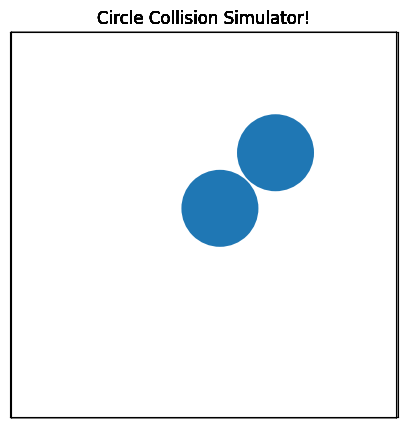

In [182]:
circle_list = [(Circle(rad,pos,dir)) for rad,pos,dir in zip(circle_radii,circle_positions,circle_directions)] # create a list of Circle objects to input in Simulation object

sim = Simulation(circle_list) # create a Simulation object for the CircleAnimation object

CircleAnimation(sim).animate(interval=interval)  # run the animation finally!!!